# MOAs that pass and don't pass percent matching thresholds

Supplementary Figure 17, related to Figure 4.

- Panel A - MOA word cloud of MOAs that consistently pass matching thresholds
- Panel B - Comparing pairwise correlation to average precision
- Panel C - Comparing counts of MOAs that pass and consistently don't pass MOA thresholds
- Panel D - All non-matching MOAs

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(ggrepel))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "supplementary", "figureS17_moawordhits")
extensions <- c(".png", ".pdf")

In [3]:
results_dir <- file.path("../1.Data-exploration/Consensus/")

# To add analysis facet of all dose percent matching
updated_dose_order <- c(dose_order, "All")

In [4]:
pm_cellpainting_list <- load_percent_matching(assay = "cellpainting", results_dir = results_dir, append_all_dose = TRUE)
pm_l1000_list <- load_percent_matching(assay = "l1000", results_dir = results_dir, append_all_dose = TRUE)

print(dim(pm_cellpainting_list[["percent_matching"]]))
print(dim(pm_l1000_list[["percent_matching"]]))

print(dim(pm_cellpainting_list[["percent_matching_pvals"]]))
print(dim(pm_l1000_list[["percent_matching_pvals"]]))

[1] 1477    5
[1] 1477    5
[1] 1477    5
[1] 1477    5


In [5]:
p_val_alpha_thresh <- 0.05
plot_thresh <- -log10(p_val_alpha_thresh)

no_replicates_thresh <- 3

cell_painting_pm_df <- pm_cellpainting_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_df <- pm_l1000_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_df <- dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df)

cell_painting_pm_pval_df <- pm_cellpainting_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- pm_l1000_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_pval_df <- dplyr::bind_rows(cell_painting_pm_pval_df, l1000_pm_pval_df)

pm_df <- pm_df %>%
    dplyr::left_join(pm_pval_df, by = c("moa", "dose", "assay", "no_of_replicates")) %>%
    dplyr::mutate(pass_thresh = p_value < p_val_alpha_thresh) %>%
    dplyr::mutate(neg_log_10_p_val = -log10(p_value))

pm_df$dose <- factor(pm_df$dose, levels = updated_dose_order)

pm_df$neg_log_10_p_val[pm_df$neg_log_10_p_val == Inf] = 3.5

print(dim(pm_df))
head(pm_df)

[1] 1946    8


moa,no_of_replicates,dose,matching_score,assay,p_value,pass_thresh,neg_log_10_p_val
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
acat inhibitor,3,0.04 uM,0.004444607,Cell Painting,0.513,FALSE,0.2898826
acetylcholine receptor agonist,8,0.04 uM,0.005142343,Cell Painting,0.576,FALSE,0.2395775
acetylcholine receptor antagonist,21,0.04 uM,0.019262183,Cell Painting,0.017,TRUE,1.7695511
adenosine receptor agonist,3,0.04 uM,0.009583710,Cell Painting,0.442,FALSE,0.3545777
adenosine receptor antagonist,4,0.04 uM,0.001703919,Cell Painting,0.612,FALSE,0.2132486
adrenergic receptor agonist,20,0.04 uM,0.005015938,Cell Painting,0.683,FALSE,0.1655793


In [6]:
moa_count_filter <- 2

moa_match_df <- pm_df %>% dplyr::filter(pass_thresh)

consistent_match_moa_df <- moa_match_df %>%
    dplyr::group_by(assay, moa) %>%
    dplyr::tally() %>%
    dplyr::filter(n >= !!moa_count_filter) %>%
    reshape2::dcast(moa ~ assay, value.var = "n") %>%
    tidyr::replace_na(
        list(
            `Cell Painting` = 0,
            L1000 = 0
        )
    ) %>%
    dplyr::mutate(x_axis_location = "Cell Painting")

consistent_match_moa_df$x_axis_location[consistent_match_moa_df$L1000 > 0] = "L1000"
consistent_match_moa_df$x_axis_location[(consistent_match_moa_df$L1000 > 0 & consistent_match_moa_df$`Cell Painting` > 0)] = "Both"

# Define the order to plot the text
cell_painting_order <- consistent_match_moa_df %>%
    dplyr::filter(x_axis_location == "Cell Painting") %>%
    dplyr::arrange(`Cell Painting`, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

l1000_order <- consistent_match_moa_df %>%
    dplyr::filter(x_axis_location == "L1000") %>%
    dplyr::arrange(L1000, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

both_order <- consistent_match_moa_df %>%
    dplyr::mutate(both_count = (`Cell Painting` + L1000) / 2) %>%
    dplyr::filter(x_axis_location == "Both") %>%
    dplyr::arrange(both_count, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

full_moa_plot_order <- dplyr::bind_rows(cell_painting_order, l1000_order, both_order)

plot_ready_moa_text_df <- consistent_match_moa_df %>% dplyr::left_join(full_moa_plot_order, by = "moa") %>%
    dplyr::mutate(replicate_count = `Cell Painting` + L1000)

plot_ready_moa_text_df$x_axis_location <- factor(plot_ready_moa_text_df$x_axis_location, levels = c("Cell Painting", "Both", "L1000"))

plot_ready_moa_text_df <- plot_ready_moa_text_df %>%
    dplyr::mutate(moa_with_replicate_count = paste0(moa, " (", replicate_count, ")"))

print(length(unique(plot_ready_moa_text_df$moa)))
head(plot_ready_moa_text_df)

[1] 57


,moa,Cell Painting,L1000,x_axis_location,y_axis_location,replicate_count,moa_with_replicate_count
,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
1,acetylcholine receptor agonist,0,3,L1000,28,3,acetylcholine receptor agonist (3)
2,adenosine receptor antagonist,0,3,L1000,31,3,adenosine receptor antagonist (3)
3,akt inhibitor,5,0,Cell Painting,49,5,akt inhibitor (5)
4,alk tyrosine kinase receptor inhibitor,3,2,Both,1,5,alk tyrosine kinase receptor inhibitor (5)
5,androgen receptor agonist,7,4,Both,34,11,androgen receptor agonist (11)
6,androgen receptor modulator,2,0,Cell Painting,1,2,androgen receptor modulator (2)


In [7]:
# Prep additional data for plotting
replicate_counts_df <- pm_df %>%
    tidyr::drop_na() %>%
    dplyr::group_by(moa, dose) %>%
    dplyr::mutate(avg_replicate_count = mean(no_of_replicates)) %>%
    dplyr::select(moa, dose, avg_replicate_count) %>%
    dplyr::ungroup() %>%
    dplyr::distinct()

cp_pass_thresh <- pm_df %>%
    dplyr::filter(assay == "Cell Painting", pass_thresh) %>%
    dplyr::select(moa, dose, pass_thresh) %>%
    dplyr::rename(pass_thresh_cellpainting = pass_thresh)

l1000_pass_thresh <- pm_df %>%
    dplyr::filter(assay == "L1000", pass_thresh) %>%
    dplyr::select(moa, dose, pass_thresh) %>%
    dplyr::rename(pass_thresh_l1000 = pass_thresh)

pass_thresh_both <- cp_pass_thresh %>%
    dplyr::full_join(l1000_pass_thresh, by = c("moa", "dose")) %>%
    tidyr::replace_na(list(pass_thresh_cellpainting = FALSE, pass_thresh_l1000 = FALSE)) %>%
    dplyr::mutate(pass_both = pass_thresh_cellpainting + pass_thresh_l1000) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE)) %>%
    dplyr::mutate(moa_color_passing = 0)

pass_thresh_both$moa_color_passing[pass_thresh_both$pass_both] <- "#DF74F0"
pass_thresh_both$moa_color_passing[(pass_thresh_both$pass_thresh_cellpainting & !pass_thresh_both$pass_both)] <- paste(assay_colors["Cell Painting"])
pass_thresh_both$moa_color_passing[(pass_thresh_both$pass_thresh_l1000 & !pass_thresh_both$pass_both)] <- assay_colors["L1000"]

plot_ready_pm_df <- pm_df %>%
    reshape2::dcast(moa + dose ~ assay, value.var = "matching_score") %>%
    tidyr::drop_na() %>%
    dplyr::left_join(replicate_counts_df, by = c("moa", "dose")) %>%
    dplyr::left_join(pass_thresh_both, by = c("moa", "dose")) %>%
    tidyr::replace_na(
        list(
            pass_thresh_cellpainting = FALSE,
            pass_thresh_l1000 = FALSE,
            pass_both = FALSE,
            moa_color_passing = "lightgrey"
        )
    )

In [8]:
moa_labels <- c("None", "L1000", "Cell Painting", "Both")
moa_colors <- c("lightgrey", "#8AA7F0", "#F0C178", "#DF74F0")

names(moa_colors) <- moa_labels
names(moa_labels) <- moa_labels

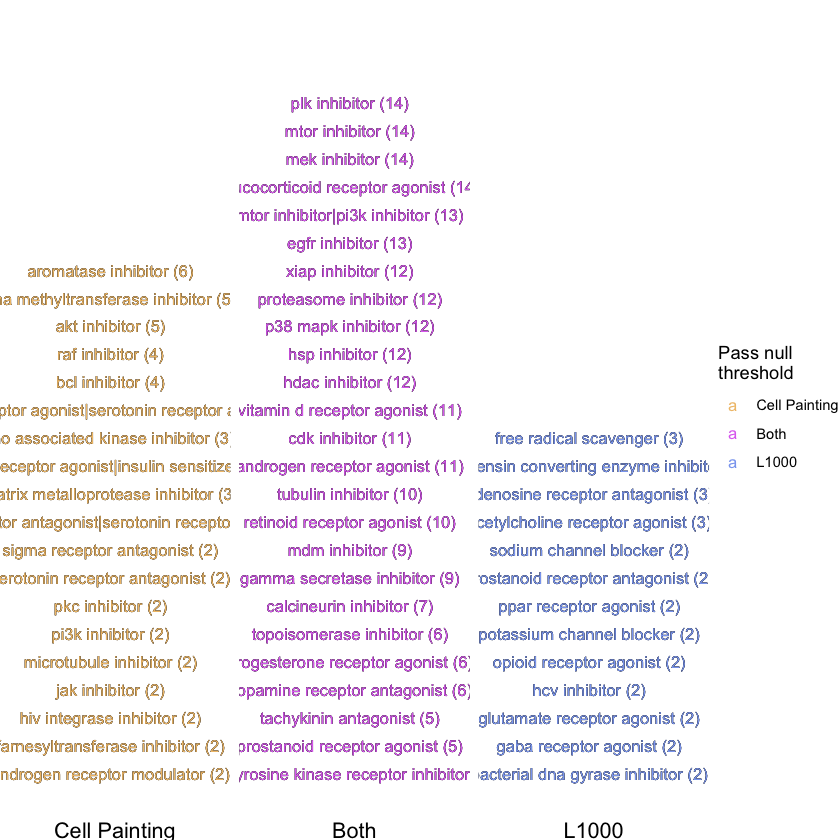

In [9]:
word_gg <- (
    ggplot(plot_ready_moa_text_df, aes(y = y_axis_location, x = 0))
    + geom_text(
        aes(
            label = moa_with_replicate_count,
        ),
        color = "black",
        size = 3.5
    )
    + geom_text(
        aes(
            label = moa_with_replicate_count,
        ),
        color = "black",
        size = 3.5
    )
    + geom_text(
        aes(
            label = moa_with_replicate_count,
            color = x_axis_location
        ),
        size = 3.5                                                                                                                                            
    )
    + facet_wrap("~x_axis_location", strip.position = "bottom")
    + theme_void()
    + theme(strip.text = element_text(size = 13))
    + scale_color_manual(
        "Pass null\nthreshold",
        values = moa_colors
    )
    + xlim(-110, 120)
    + ylim(0, 80)
    + guides(color = guide_legend(order = 1))
)

word_gg

## Dose specific precision

In [10]:
# Load precision scores
precision_file <- file.path("..", "1.Data-exploration", "results", "moa_target_precision.tsv.gz")

precision_cols <- readr::cols(
  drug_impact = readr::col_character(),
  dose = readr::col_character(),
  avg_precision = readr::col_double(),
  impact_category = readr::col_character(),
  assay = readr::col_character()
)

# Load and process data for plotting
precision_df <- readr::read_tsv(precision_file, col_types = precision_cols) %>%
    reshape2::dcast(drug_impact+dose+impact_category+dose_comparison~assay, value.var = "avg_precision") %>%
    dplyr::arrange(desc(L1000))

# Separate the dose comparison and recode dose separately
same_dose_precision_df <- precision_df %>%
    dplyr::filter(dose_comparison == "same_dose")

same_dose_precision_df$dose <- as.numeric(paste(same_dose_precision_df$dose))
same_dose_precision_df$dose <- dplyr::recode_factor(same_dose_precision_df$dose, !!!dose_rename)

precision_df <- dplyr::bind_rows(
    same_dose_precision_df,
    precision_df %>%
        dplyr::filter(dose_comparison != "same_dose")
    ) %>%
    tidyr::drop_na()

precision_df$dose <- factor(precision_df$dose, levels = updated_dose_order)

impact_recode <- c("moa" = "MOA", "target" = "Gene target")
precision_df$impact_category <- dplyr::recode_factor(precision_df$impact_category, !!!impact_recode)
precision_df$impact_category <- factor(precision_df$impact_category, levels = impact_recode)

print(dim(precision_df))
head(precision_df, 5)

Warning message in bind_rows_(x, .id):
“binding factor and character vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


[1] 5005    6


,drug_impact,dose,impact_category,dose_comparison,cell_painting,L1000
,<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>
1,HSP90AA1,0.04 uM,Gene target,same_dose,0.6666667,1
2,HSP90AA1,0.12 uM,Gene target,same_dose,0.2500000,1
3,inosine monophosphate dehydrogenase inhibitor,10 uM,MOA,same_dose,0.5833333,1
4,MAP3K1,10 uM,Gene target,same_dose,0.1428571,1
5,proteasome inhibitor,3.33 uM,MOA,same_dose,0.9093855,1


In [11]:
# How many counts
precision_df %>%
    dplyr::select(drug_impact, impact_category) %>%
    dplyr::distinct() %>%
    dplyr::group_by(impact_category) %>%
    dplyr::tally()

impact_category,n
<fct>,<int>
MOA,208
Gene target,507


In [12]:
# Merge precision scores and percent matching
precision_melt_df <- precision_df %>%
    dplyr::filter(impact_category == 'MOA') %>%
    reshape2::melt(
        id.vars = c("drug_impact", "dose", "impact_category"),
        variable.name = "assay",
        value.name = "avg_precision"
    ) 

precision_melt_df$assay <- dplyr::recode_factor(precision_melt_df$assay, "cell_painting" = "Cell Painting")
precision_melt_df <- precision_melt_df %>%
    dplyr::inner_join(dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df), by = c("drug_impact" = "moa", "dose" = "dose", "assay" = "assay"))

precision_melt_df$dose <- factor(precision_melt_df$dose, levels = updated_dose_order)

precision_melt_df$avg_precision <- as.numeric(paste(precision_melt_df$avg_precision))

output_file <- file.path("data", "moa_target_full_avgprecision_matching_score.tsv")
precision_melt_df %>% readr::write_tsv(output_file)

print(dim(precision_melt_df))
head(precision_melt_df, 2)

Warning message:
“Column `dose` joining factor and character vector, coercing into character vector”
Warning message:
“Column `assay` joining factor and character vector, coercing into character vector”


[1] 1928    7


,drug_impact,dose,impact_category,assay,avg_precision,no_of_replicates,matching_score
,<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
1,proteasome inhibitor,3.33 uM,MOA,Cell Painting,0.9093855,4,0.5364523
2,proteasome inhibitor,10 uM,MOA,Cell Painting,0.9242424,4,0.5921636


In [13]:
# Calculate pairwise correlations between median correlation and avg. precision
precision_cor_df <- precision_melt_df %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::summarise(cor_coef = cor.test(avg_precision, matching_score, method="pearson")$estimate) %>%
    dplyr::mutate(cor_coef_round = paste("r =", round(cor_coef, 2))) %>%
    dplyr::ungroup()

head(precision_cor_df)

assay,dose,cor_coef,cor_coef_round
<chr>,<fct>,<dbl>,<chr>
Cell Painting,0.04 uM,0.9130863,r = 0.91
Cell Painting,0.12 uM,0.9205970,r = 0.92
Cell Painting,0.37 uM,0.8836790,r = 0.88
Cell Painting,1.11 uM,0.8976015,r = 0.9
Cell Painting,3.33 uM,0.9011743,r = 0.9
Cell Painting,10 uM,0.8728791,r = 0.87


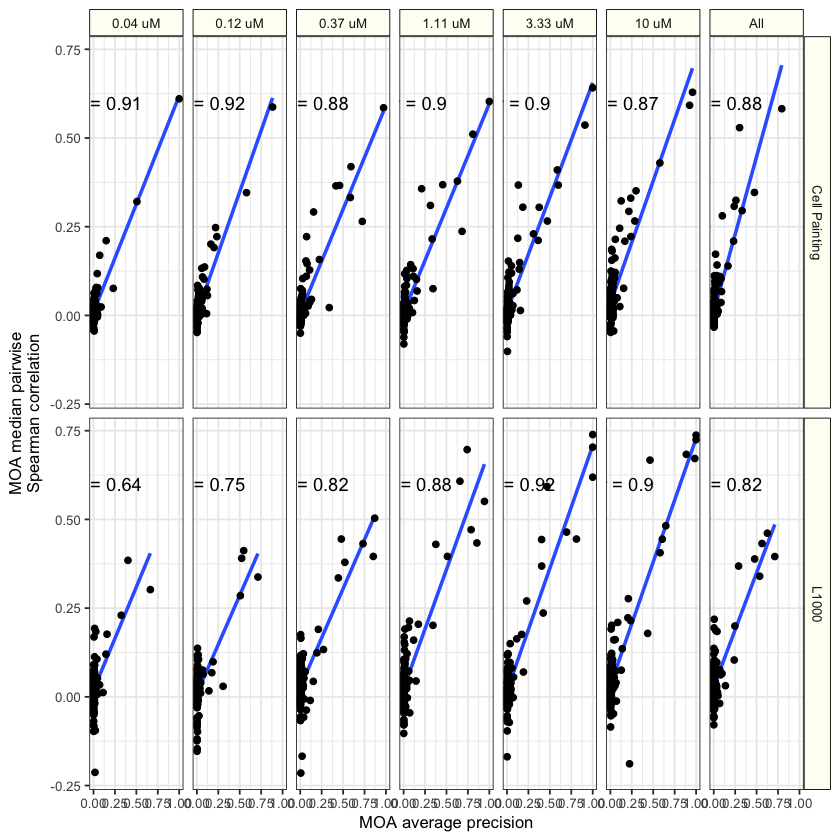

In [14]:
precision_match_gg <- (
    ggplot(precision_melt_df)
    + geom_text(data=precision_cor_df, x = .2, y = .6, aes(label=cor_coef_round))
    + geom_smooth(method="lm", se = FALSE, formula=y~x, aes(x = avg_precision, y = matching_score))
    + geom_point(aes(x = avg_precision, y = matching_score))
    + figure_theme
    + facet_grid("assay~dose")
    + xlab("MOA average precision")
    + ylab("MOA median pairwise\nSpearman correlation")
)

precision_match_gg

In [15]:
all_dose_pass_df <- list()
for (use_dose in unique(pm_df$dose)) {
  all_dose_pass_df[[use_dose]] <- pm_df %>%
      dplyr::filter(dose == !!use_dose) %>%
      reshape2::dcast("moa~assay", value.var = "pass_thresh") %>%
        dplyr::mutate(dose = use_dose) %>%
    dplyr::mutate(
        `CP` = sum(`Cell Painting`),
        `L1K` = sum(`L1000`),
        `Neither`= sum(!(`Cell Painting` + `L1000`))
    ) %>%
    dplyr::select(dose, `CP`, `L1K`, `Neither`) %>%
    dplyr::distinct()
}

all_dose_pass_df <- dplyr::bind_rows(all_dose_pass_df) %>%
    reshape2::melt(id.vars = "dose", variable.name = "assay", value.name = "pass_thresh_count")

all_dose_pass_df$dose <- factor(all_dose_pass_df$dose, levels = updated_dose_order)

all_dose_pass_df

dose,assay,pass_thresh_count
<fct>,<fct>,<int>
0.04 uM,CP,20
0.12 uM,CP,22
0.37 uM,CP,25
1.11 uM,CP,29
3.33 uM,CP,36
10 uM,CP,35
All,CP,93
0.04 uM,L1K,9
0.12 uM,L1K,13


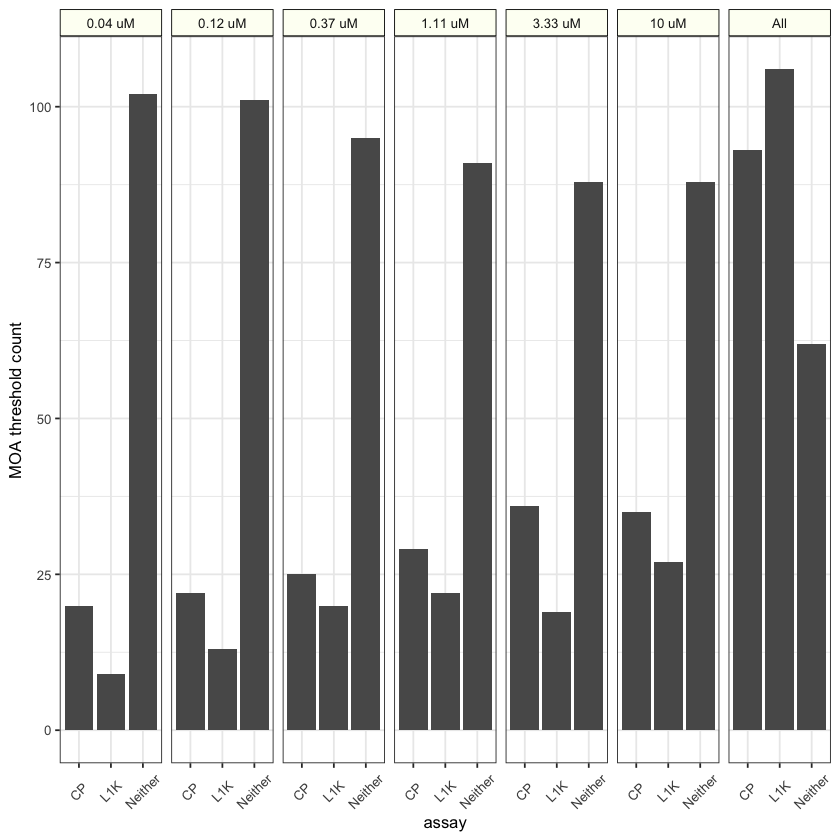

In [16]:
no_match_bar_gg <- (
    ggplot(all_dose_pass_df, aes(x = assay, y = pass_thresh_count))
    + geom_bar(stat="identity")
    + facet_grid("~dose")
    + figure_theme
    + ylab("MOA threshold count")
    + theme(axis.text.x = element_text(angle = 45, vjust = 0.5))
)

no_match_bar_gg

In [17]:
# Identify which MOAs do not match in either assay at any dose
no_match_df <- pm_df %>% 
    reshape2::dcast("moa+dose~assay", value.var="pass_thresh") %>%
    dplyr::mutate(pass_neither = !(`Cell Painting` + `L1000`)) %>%
    dplyr::filter(pass_neither) %>%
    dplyr::group_by(moa) %>%
    dplyr::mutate(neither_count = n()) %>%
    # 6 doses, plus the "All" comparison
    dplyr::filter(neither_count >= 7) %>%
    dplyr::select(moa) %>%
    dplyr::distinct()

print(dim(no_match_df))

[1] 29  1


In [18]:
no_match_scores_df <- pm_df %>% 
    reshape2::dcast("moa+dose~assay", value.var="matching_score") %>%
    dplyr::filter(moa %in% no_match_df$moa) %>%
    dplyr::group_by(moa) %>%
    dplyr::mutate(
        sum_matching_score = sum(`Cell Painting`) + sum(`L1000`),
        sum_matching_score_cp = sum(`Cell Painting`),
        sum_matching_score_l1k = sum(`L1000`)
    ) %>%
    dplyr::select(moa, sum_matching_score, sum_matching_score_cp, sum_matching_score_l1k) %>%
    dplyr::distinct() %>%
    dplyr::arrange(sum_matching_score)

head(no_match_scores_df, 2)

moa,sum_matching_score,sum_matching_score_cp,sum_matching_score_l1k
<chr>,<dbl>,<dbl>,<dbl>
acat inhibitor,-0.5014927,-0.13265089,-0.3688418
xanthine oxidase inhibitor,-0.2147471,-0.07565353,-0.1390936


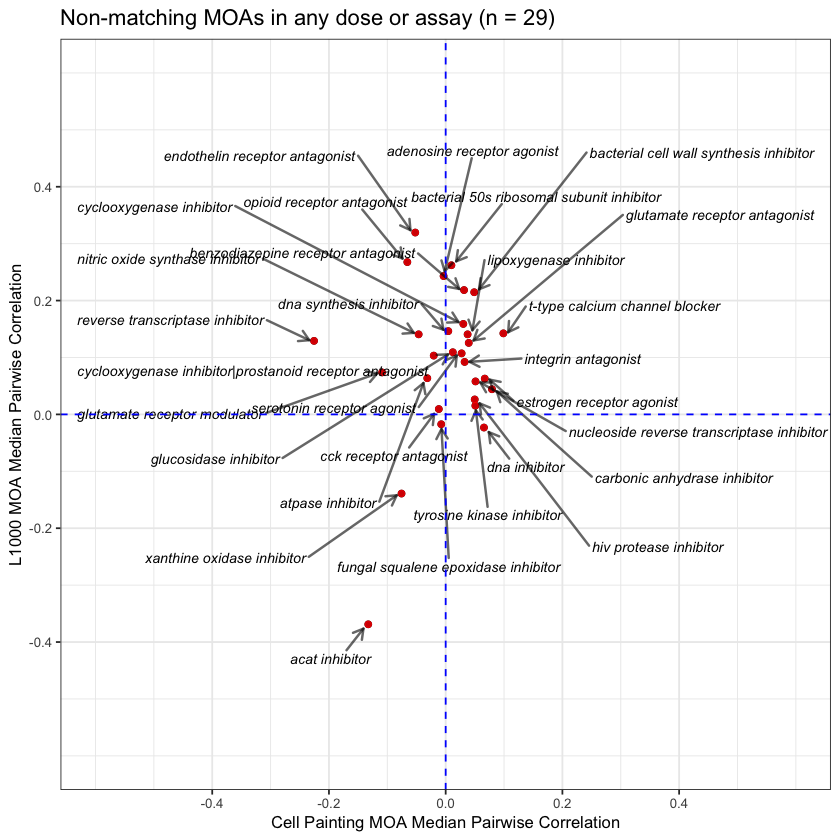

In [19]:
moa_logic <- (
    no_match_scores_df$sum_matching_score_cp < 0 |
    no_match_scores_df$sum_matching_score_l1k < 0
    )

no_match_gg <- (
    ggplot(no_match_scores_df, aes(x = sum_matching_score_cp, y = sum_matching_score_l1k))
    + geom_point()
    + figure_theme
    + xlab("Cell Painting MOA Median Pairwise Correlation")
    + ylab("L1000 MOA Median Pairwise Correlation")
    + ggtitle(paste0("Non-matching MOAs in any dose or assay", " (n = ", dim(no_match_scores_df)[1], ")"))
    + geom_point(color = "red", alpha = 0.8)
    + geom_text_repel(
        data = no_match_scores_df,
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.7,
        segment.alpha = 0.6,
        size = 3,
        fontface = "italic",
        box.padding = 0.7,
        point.padding = 0.4,
        force = 20,
        aes(
            x = sum_matching_score_cp,
            y = sum_matching_score_l1k,
            label = moa,
        )
    )
    + geom_hline(yintercept = 0, color = "blue", linetype = "dashed")
    + geom_vline(xintercept = 0, color = "blue", linetype = "dashed")
    + scale_x_continuous(breaks = seq(-0.4, 0.4, 0.2), limits = c(-0.6, 0.6))
    + scale_y_continuous(breaks = seq(-0.4, 0.4, 0.2), limits = c(-0.6, 0.6))
)

no_match_gg

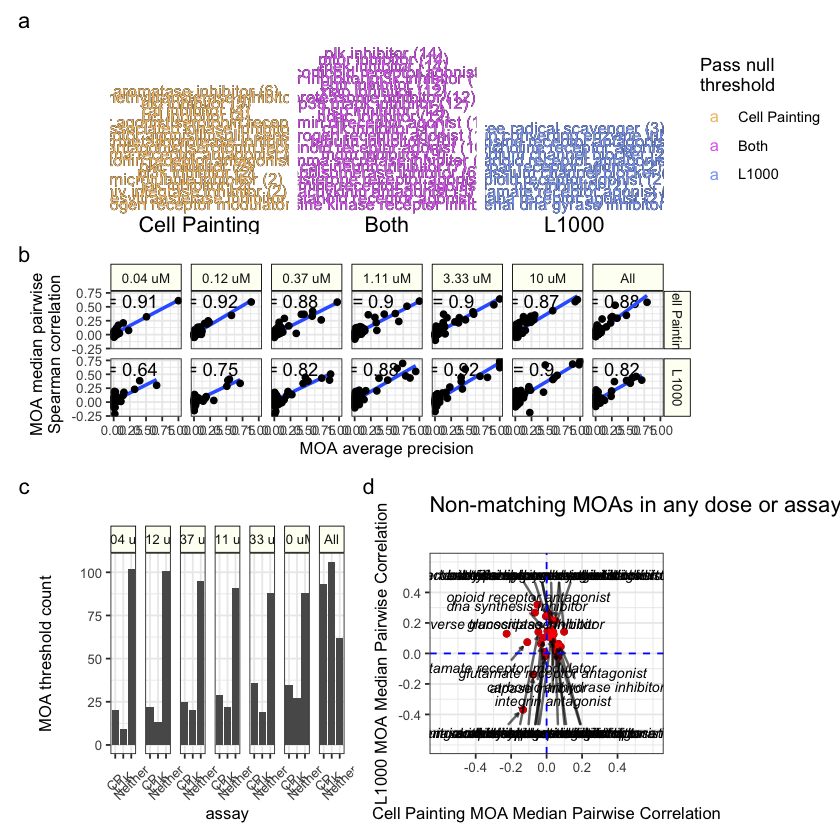

In [20]:
# Compile figure
sup_fig_gg <- (
    word_gg /
    precision_match_gg /
    (no_match_bar_gg + no_match_gg)
    + plot_layout(heights = c(1.1, 0.75, 1.2))
    + plot_annotation(tag_levels = "a")
)

for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, sup_fig_gg, width = 14.5, height = 13.5, dpi = 500)
}

sup_fig_gg